# `RATstart` 

This section deals with using the direct interface to the `librat` code at a high level, through the `RATstart` software. This is a short piece of `C` code, the main role of with is to present a set of simple functions controlled by text input on the command line. One of these 'options' (option 14) gives an extremely fexible interface for defining viewing and illumination conditions for radiative transfer simulations, and it is this part of the interface that is most widely used. We will deal with option 14 in more detail elsewhere, concentrating in this section on the other options to the software.


## `RATstart` (formerly `start`)

The minimum requirement for the `RATstart` command line is the declaration of some object file to use in the simulation. An object file describes the real world geometry and scattering properties of the objects we are using in the simulation, such as some representation of a vegetation canopy. We generate a very simple object file for demonstrating `RATstart`:

!{
usemtl WHITE
v 0 0 0 
sph -1 100
!}

Other than that, its functionality is mainly controlled though a series of option codes read on the input. 

Valid options are (currently) between 0 and 16, inclusive. If we give a non-valid option code, we get the help message:

In [13]:
%%bash 
# a simple object file
# and invalid code: 1000 
# to see the options
BPMS="../..";TEMP=/tmp;cd $BPMS;BPMS=$(pwd)
# a very simple object file
cat <<EOF > $TEMP/tmp.$$.obj
!{
usemtl WHITE
v 0 0 0 
sph -1 100
!}
EOF
export LD_LIBRARY_PATH="src:${LD_LIBRARY_PATH}"
export DYLD_LIBRARY_PATH="src:${DYLD_LIBRARY_PATH}"
src/RATstart $TEMP/tmp.$$.obj <<< 1000; 

options:
	 0                   : quit
	 1 n s1x s1y s1z ... : set sun vectors
	 2                   : print sun vectors
	 3 n b1 w1 ...i bn wn: set wavebands
	 4                   : print wavebands
	 5 file.obj          : read object file
	 6 fx fy fz dx dy dz : trace ray from f in direction d
	 7                   : get and print materials
	 8                   : print object information
	 9                   : print info on materials used
	 10                  : get and set verbosity level (0-1)
	 11                  : get and print object bbox information
	 13                  : same as 14 assuming filenames camera.dat light.dat
	 14 camera.dat light.dat                : ray tracing using defined camera & illumination
	 16 cx cy cz sx sy nrows ncols rpp name : produce a height map in name
Extent of scene is {-99.990000 -99.990000 -99.990000} to {100.010000 100.010000 100.010000} accept? (y/n)? How many samples in each dimension? 512 512 3  accept? (y/n)? How many histogram samples? 

As noted above, we most commonly use option `14`. This allows the definition of a 'camera' and 'light source' defined in the files `camera.dat` and `light.dat` here, respectively and gives a very general interface for radiative transfer simulations. Using the code then amounts to setting up camera and illumination files for the scenarious you are interested in, which greatly simplifies the interface. 



### Initialisation shells

Before proceeding, we make sure we set appropriate environment variables to run a set of examples with RATstart. We also want to test that the software runs ok. We generate two `bash` shells to achieve this here, and use these in subsequent notes. 

You can modify any of this as a user, but be careful not to break it! 🙄. In an emergency, you can always just re-download this set of notes and software from [github](https://github.com/profLewis/librat) and start again.

If you want to know more about setting up this sort of file, and what it all means, see [Appendix 1](Appendix1). At the moment, you just need to be aware of the need to set environment variables, but not to understand all of the intricacies.

We simplify the interface for the environment variables by setting up two configuration files `examples_init.sh` and `local_init.sh`. We then run them, to test the code.

In [1]:
%%bash
#
# create local_init.sh
# for local initialisation
#

cat <<EOF > local_init.sh
#!/bin/bash
export HERE=$(pwd)
export BPMS=\${BPMS-\${HERE%librat*}librat}
export BPMSROOT=\$BPMS/test/test_examples
mkdir -p \$BPMSROOT
export INIT=\$BPMSROOT/examples_init.sh
EOF

In [52]:
%%bash
#
# create examples_init.sh
# for examples initialisation
#

source ./local_init.sh
# create the init shell
cat <<EOF > $INIT
#!/bin/bash
#
# defaults
#
export BPMS=\${BPMS-$BPMS}
export BPMSROOT=\${BPMSROOT-$BPMS/test/test_examples}
lib=\${lib-"\$BPMS/src"}
bin=\${bin-"\$BPMS/src"}
VERBOSE=\${VERBOSE-0}
export TEMP=\${TEMP-/tmp}

# set up required environment variables for bash
export LD_LIBRARY_PATH="\${lib}:\${LD_LIBRARY_PATH}"
export DYLD_LIBRARY_PATH="\${lib}:\${DYLD_LIBRARY_PATH}"
export PATH="\${bin}:\${PATH}"

export MATLIB=\$BPMSROOT
export RSRLIB=\$BPMSROOT
export ARARAT_OBJECT=\$BPMSROOT
export DIRECT_ILLUMINATION=\$BPMSROOT
export BPMS_FILES=\$BPMSROOT
export SKY_ILLUMINATION==\$BPMSROOT

if [ "\$(which RATstart)" == "\${bin}/RATstart" ]
then
  if [ "\$VERBOSE" == 1 ]; then
      echo "RATstart found ok"
  fi
else
  # we should create them
  make clean all 
fi
EOF
chmod +x $INIT

In [53]:
%%bash
# run test
source ./local_init.sh
export VERBOSE=1
$INIT

RATstart found ok


## Environment variables

If we take a quick look at the `examples_init.sh` file we generated, we see:

In [4]:
%%bash
source ./local_init.sh
cat $INIT

#!/bin/bash
#
# defaults
#
export BPMS=${BPMS-/Users/plewis/librat}
export BPMSROOT=${BPMSROOT-/Users/plewis/librat/test/test_examples}
lib=${lib-"$BPMS/src"}
bin=${bin-"$BPMS/src"}
VERBOSE=${VERBOSE-0}
export TEMP=${TEMP-/tmp}

# set up required environment variables for bash
export LD_LIBRARY_PATH="${lib}:${LD_LIBRARY_PATH}"
export DYLD_LIBRARY_PATH="${lib}:${DYLD_LIBRARY_PATH}"
export PATH="${bin}:${PATH}"

export MATLIB=$BPMSROOT
export RSRLIB=$BPMSROOT
export ARARAT_OBJECT=$BPMSROOT
export DIRECT_ILLUMINATION=$BPMSROOT
export BPMS_FILES=$BPMSROOT
if [ "$(which RATstart)" == "${bin}/RATstart" ]
then
  if [ "$VERBOSE" == 1 ]; then
      echo "RATstart found ok"
  fi
else
  # we should create them
  make clean all 
fi



We might notice that `examples_init.sh` sets a number of environment variables, namely `MATLIB`, `RSRLIB` etc. 

If you are interested in the details, the meaning of these is given in the table below. 

Alternatively, just notice that in the init shell, all of these variables are set to  `BPMSROOT`, so if we want to point to the location of an object and material database for librat, we need only set the environment variable  `BPMSROOT` appropriately. In this case it defaults to `$BPMS/test/test_example`.






**Table explaining librat object environment variables:**

| Name | File types |
|:-|:-|
| `MATLIB` | material library e.g. [`plants.matlib`](test/test_examples/plants.matlib), all materials defined in a material library e.g. [`refl/white.dat`](test/test_examples/refl/white.dat)|
| `ARARAT_OBJECT` | (extended) wavefront object files e.g. [`first.obj`](test/test_examples/first.obj)  |
| `DIRECT_ILLUMINATION` | spectral files for direct illumination: those defined in -RATdirect command line option |
| `RSRLIB` | sensor waveband files: those defined in -RATsensor_wavebands command line option |
| `BPMS_FILES` | Not used |

You can set all of these to the same value  as above (`$BPMSROOT`), in which case the database of files is all defined relative to that location in the file system. This is the most typical use of `librat`. We illustrate this setup below for the `librat` distribution, where a set of examples use files from the directory `test/test_example`.

Additionally in `librat`, the following environment variables can be set to extend the size of some aspects of the model. You would only need to use these in some extreme case.

**Table explaining additional librat environment variables:**

| Name | Purpose |
|:-|:-|
| `MAX_GROUPS` | Maximum number of groups allowed (100000) |
| `PRAT_MAX_MATERIALS` | Maximum number of materials allowed (DEFAULT_PRAT_MAX_MATERIALS=1024 in `mtllib.h`) |


If you want to run a shell that uses the setup, you will need to use the command `source` to export the variables to your shell.

You can test the init file by running the cell (shell) below. 

In [5]:
%%bash

# source if we want the info in this shell
source ./local_init.sh
source $INIT

echo "MATLIB is set to $MATLIB"
echo "RSRLIB is set to $RSRLIB"

MATLIB is set to /Users/plewis/librat/test/test_examples
RSRLIB is set to /Users/plewis/librat/test/test_examples


```
EXERCISE 1.1

    1. Try changing the environment variable VERBOSE to 1 (True) or 0 (False) to see the effect.
    
    2. You can change the name of the directory where the object and material files are through the environment variable BPMSROOT. See if you can find what BPMSROOT is set to, and also see if yoiu can modify it.
    
```

**Answers below:**

In [6]:
%%bash
#----------------------
# this part same as above
#
# test the init file
# set INIT script
source ./local_init.sh
source $INIT
#----------------------

# 1.1.1: Try changing the environment variable VERBOSE to 1
# (True) and 0 (False) to see the effect.

# ANSWER
# this sets verbose mode and prints a message
# 'RATstart found ok' if it finds the librat RATstart
# executable
echo  "----set VERBOSE 1---"
export VERBOSE=1
source $INIT
# it would be correct, in this instance to use
# export VERBOSE=1
# $INIT
# as there is no real need to source the file
# Above, the export in 'export VERBOSE=1' is not
# strictly needed if we source $INIT, but it is otherwise

# this turns off the verbose mode
# so no message is printed
echo "----set VERBOSE 0---"
export VERBOSE=0
source $INIT
# it would be correct, in this instance to use
# export VERBOSE=0
# $INIT
# as there is no real need to source the file
# Above, the export in 'export VERBOSE=1' is not
# strictly needed if we source $INIT, but it is otherwise

# 1.1.2: You can change the name of the directory where the 
# object and material files are through the 
# environment variable BPMSROOT. 
# See if you can find what BPMSROOT is set to, 
# and also see if yoiu can modify it.

# ANSWER
# we need to see the value of the 
# environment variable BPMSROOT, but we need it 
# in this shell. So we *source* the file
# rather than running it.
echo "----get BPMSROOT---"
source $INIT
echo "BPMSROOT is $BPMSROOT"
echo "----set BPMSROOT---"
# To change it, just set it before sourcing
export BPMSROOT="/tmp"
source $INIT
echo "BPMSROOT is $BPMSROOT"

----set VERBOSE 1---
RATstart found ok
----set VERBOSE 0---
----get BPMSROOT---
BPMSROOT is /Users/plewis/librat/test/test_examples
----set BPMSROOT---
BPMSROOT is /tmp


## Making files

We will create the files we need as we go along, using `bash` shell `cat <<EOF > filename` syntax. You may have noticed that we did this above in creating the `init` file. 

If we type:

    cat <<EOF > filename
    this is line 1
    this is line 2
    EOF
    
then a file called `filename` will be generated, containing the information up to the `EOF` marker:

    this is line 1
    this is line 2
   
   
Wew can try that now:

We first create the `BPMSROOT` directory to do our work (using the `linux` command `mkdir -p` in a `bash` shell):

In [7]:
%%bash
source ./local_init.sh
echo $BPMSROOT

mkdir -p $BPMSROOT

/Users/plewis/librat/test/test_examples


Now we will put some text some files in that directory. We will be creating files that we need to run a radiative transfer simulation. We will look into what these mean and their formats later in the notes.

In [8]:
%%bash

source ./local_init.sh;source $INIT

# simple object file
# with green plane
# and sphere of radius 100 mm
# centred at (0,0,0)
cat <<EOF > $BPMSROOT/first.obj
# My first object file
mtllib plants.matlib 
usemtl green 
v 0 0 0 
v 0 0 1 
plane -1 -2 
!{
usemtl white 
!{ 
v 0 0 0 
sph -1 100
!} 
!}
EOF

# wavelengths (nm)
cat <<EOF > $BPMSROOT/wavebands.dat
1 650
2 550
3 450
EOF

# spectrum for white
cat <<EOF > $BPMSROOT/white.dat
450 1
550 1
650 1
EOF

# spectrum for green
cat <<EOF > $BPMSROOT/green.dat
450 0.1
550 0.5
650 0.1
EOF

# library listing materials
cat <<EOF > $BPMSROOT/plants.matlib 
srm green green.dat
srm white white.dat
EOF

And now run a simple example:

In [63]:
%%bash
source ./local_init.sh;source $INIT

echo 11 | RATstart -RATsensor_wavebands $BPMS/test/test_examples/wavebands.dat \
                -RATsun_position 0 1 1 $BPMS/test/test_examples/first.obj

x: -99.980001 100.020001
y: -99.980001 100.020001
z: -99.980001 100.020001
bbox centre @ 0.020000 0.020000 0.020000


In [64]:
%%bash
source ./local_init.sh;source $INIT

echo "16 0 0 400 400 400  200 200 1 $BPMS/test/test_examples/out.hips" | RATstart \
    -RATsensor_wavebands $BPMS/test/test_examples/wavebands.dat  \
    -RATv  -RATsun_position 0 1 1 $BPMS/test/test_examples/first.obj

RATstart:
	VERBOSE flag on (-v option)
read_spectral_file:	3 data entries read in file /Users/plewis/librat/test/test_examples/wavebands.dat
( 99.9975)              

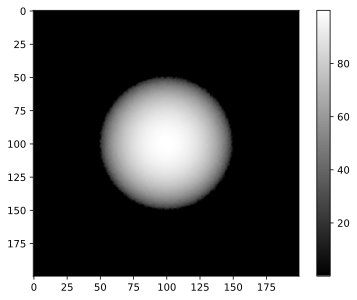

In [65]:
from libhipl import Hipl
import pylab as plt

f = '../../test/test_examples/out.hips'
rabbit=Hipl().read(f)
plt.imshow(rabbit,cmap='gray')
plt.colorbar()

In [66]:
%%bash
source ./local_init.sh;source $INIT

echo 6 0 0 110 0 0 -1 | RATstart -RATsensor_wavebands $BPMS/test/test_examples/wavebands.dat -RATsun_position 0 1 1 $BPMS/test/test_examples/first.obj

RTD 0
order: 0	intersection point:	0.000000 0.000000 100.000010
		ray length:		9.999990
		intersection material:	3
		sun 0:			no hit
		sky  :			reflectance
		diffuse:		1.000000 1.000000 1.000000 


In [56]:
%%bash
pwd

/Users/plewis/librat/docs/source


In [77]:
%%bash
pwd
source ./local_init.sh
BPMSROOT=$BPMS/obj
source $INIT
# option 8
RATstart $BPMS/obj/shrubs.obj << EOF
16 0 0 200 .2 .2 200 200 3 $BPMS/obj/out.tmp.hips
EOF

/Users/plewis/librat/docs/source


( 99.9975)              

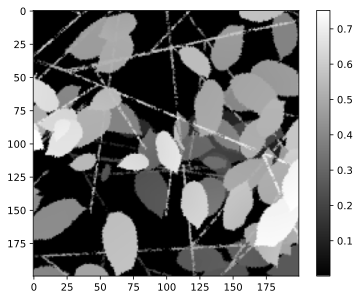

In [78]:
from libhipl import Hipl
import pylab as plt

f = '../../obj/out.tmp.hips'
plt.imshow(Hipl().read(f),cmap='gray')
plt.colorbar()

### Option 3: set wavebands

    3 n b1 w1 ...i bn wn: set wavebands

In [90]:
%%bash

### wavebands

source ./local_init.sh;source $INIT

cat <<EOF | RATstart -RATr $i $BPMS/test/test_examples/first.obj
3 3 200 20 300 20 400 20
4
EOF



# wavelength is min and width


wavebands: 202.630756 315.112106 409.173003 


### Option 4: Print wavebands

    4                   : print wavebands

In [89]:
%%bash

### wavebands

source ./local_init.sh;source $INIT

for i in $(seq 1 2 40)
do
cat <<EOF | RATstart -RATr $i $BPMS/test/test_examples/first.obj
3 3 200 20 300 20 400 20
4
EOF
done

wavebands: 202.630756 315.112106 409.173003 
wavebands: 207.892267 305.336319 407.519008 
wavebands: 213.153779 315.560532 405.865013 
wavebands: 218.415290 305.784745 404.211018 
wavebands: 203.676802 316.008958 402.557024 
wavebands: 208.938313 306.233171 400.903029 
wavebands: 214.199825 316.457384 419.249034 
wavebands: 219.461336 306.681597 417.595040 
wavebands: 204.722848 316.905810 415.941045 
wavebands: 209.984359 307.130022 414.287050 
wavebands: 215.245871 317.354235 412.633055 
wavebands: 200.507383 307.578448 410.979061 
wavebands: 205.768894 317.802661 409.325066 
wavebands: 211.030406 308.026874 407.671071 
wavebands: 216.291917 318.251087 406.017077 
wavebands: 201.553429 308.475300 404.363082 
wavebands: 206.814940 318.699513 402.709087 
wavebands: 212.076452 308.923726 401.055092 
wavebands: 217.337963 319.147938 419.401098 
wavebands: 202.599475 309.372151 417.747103 


### Option 6: trace ray from f in direction d

        6 fx fy fz dx dy dz : trace ray from f in direction d

In [92]:
%%bash
source ./local_init.sh
BPMSROOT=$BPMS/obj
source $INIT
# option 6
RATstart $BPMS/obj/shrubs.obj << EOF
6 0 0 110 0 0 -1
EOF

/Users/plewis/librat/docs/source
RTD 0
order: 0	intersection point:	-0.000009 0.000000 0.657765
		ray length:		109.342235
		intersection material:	4
		sun 0:			1 reflectance
		direct:			0.435917 
		sky  :			reflectance
		diffuse:		2.000000 


### Option 7: query materials

    7                   : get and print materials

In [96]:
%%bash
source ./local_init.sh;source $INIT

# Query materials
# option 7
RATstart $BPMSROOT/first.obj <<< 7

There are 4 materials:

***** Material 0 *****
	name: WHITE	is used? 0
	type: (0) = srm with reflectance
	Number in used material list = -1 
	nBands: 2:
0.000000 1.000000 
100000000000000000000.000000 1.000000 
***** Material 1 *****
	name: TRANSPARENT	is used? 0
	type: (10) = transparent
	Number in used material list = -1 
***** Material 2 *****
	name: green	is used? 1
	type: (0) = srm with reflectance
	Number in used material list = 0 	name: green
	nBands: 3:
450.000000 1.000000 
550.000000 1.000000 
650.000000 1.000000 
***** Material 3 *****
	name: white	is used? 1
	type: (0) = srm with reflectance
	Number in used material list = 1 	name: white
	nBands: 3:
450.000000 1.000000 
550.000000 1.000000 
650.000000 1.000000 


### Option 9: print info on materials used

        9                   : print info on materials used

In [97]:
%%bash
source ./local_init.sh; source $INIT
# option 9
RATstart $BPMSROOT/first.obj <<< 9

There are 4 materials defined
There are 2 materials used:

***** Material 0 *****
	name: green	index: 2
	type: (0) = srm with reflectance
	nBands: 3:
450.000000 1.000000 
550.000000 1.000000 
650.000000 1.000000 
***** Material 1 *****
	name: white	index: 3
	type: (0) = srm with reflectance
	nBands: 3:
450.000000 1.000000 
550.000000 1.000000 
650.000000 1.000000 


### Option 10: get and set verbosity level (0-1)

    10                  : get and set verbosity level (0-1)

In [107]:
%%bash
source ./local_init.sh;source $INIT

# interactions to set verbosity to 1
RATstart $BPMS/test/test_examples/first.obj << EOF 
10
y

EOF

# interactions to set verbosity to 0
RATstart $BPMS/test/test_examples/first.obj << EOF 
10
y
0
EOF

Verbose level is currently 0
	Change it? (y/n): 
set verbosity level (0-1): Verbose level is now 1
Verbose level is currently 0
	Change it? (y/n): 
set verbosity level (0-1): Verbose level is now 0


But normally, we would just use the command line to set this:



In [113]:
%%bash
source ./local_init.sh;source $INIT

# interactions to set verbosity to 1
RATstart -RATv 1 $BPMS/test/test_examples/first.obj << EOF 
0
EOF

# interactions to set verbosity to 0
RATstart -RATv 0 $BPMS/test/test_examples/first.obj << EOF 
0
EOF

testing object file for material library /Users/plewis/librat/test/test_examples/first.obj
testing material library plants.matlib
Found up to 4 materials in /Users/plewis/librat/test/test_examples/first.obj and preceding files
RATstart:
	VERBOSE flag on (-v option)
{GLOBAL
	(default) diffuse (reflectance) material	WHITE...

	(default) transparent material	TRANSPARENT...
reading material library plants.matlib

	diffuse material	green...
3 lines   read in file /Users/plewis/librat/test/test_examples/green.dat
2 columns read in file /Users/plewis/librat/test/test_examples/green.dat

			...read
	diffuse material	white...
3 lines   read in file /Users/plewis/librat/test/test_examples/white.dat
2 columns read in file /Users/plewis/librat/test/test_examples/white.dat

			...read
<green>PLANE{0<white>{1s[BBox: (-100.00,-100.00,-100.00) (100.00,100.00,100.00)]1}[BBox: (-99.99,-99.99,-99.99) (100.01,100.01,100.01)]0}RATstart:
	VERBOSE flag on (-v option)


### Option 11: get and print object bbox information

    11                  : get and print object bbox information

In [116]:
%%bash
source ./local_init.sh;source $INIT

# interactions to set verbosity to 1
RATstart $BPMS/test/test_examples/first.obj <<< 11 

x: -99.980001 100.020001
y: -99.980001 100.020001
z: -99.980001 100.020001
bbox centre @ 0.020000 0.020000 0.020000


In [79]:
%%bash
source ./local_init.sh;source $INIT

echo 10000 | RATstart $BPMS/test/test_examples/first.obj

options:
	 0                   : quit
	 1 n s1x s1y s1z ... : set sun vectors
	 2                   : print sun vectors
	 3 n b1 w1 ...i bn wn: set wavebands
	 4                   : print wavebands
	 5 file.obj          : read object file
	 6 fx fy fz dx dy dz : trace ray from f in direction d
	 7                   : get and print materials
	 9                   : print info on materials used
	 10                  : get and set verbosity level (0-1)
	 11                  : get and print object bbox information
	 13                  : same as 14 assuming filenames camera.dat light.dat
	 14 camera.dat light.dat                : ray tracing using defined camera & illumination
	 16 cx cy cz sx sy nrows ncols rpp name : produce a height map in name
